In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.patches import Circle
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.stattools import adfuller

In [2]:
sensor_map_df = pd.read_csv('./data/sensor_map_2.csv')
trajectories_df = pd.read_csv('./data/trajectories.csv')

In [3]:
print('Total Records: ',trajectories_df.shape[0])
print('Person ID Records: ',trajectories_df.person_id.nunique())
print('Person ID Range: ',trajectories_df.person_id.min(),':',trajectories_df.person_id.max())
print('Sensor ID Records: ',trajectories_df.sensor_id.nunique())
print('Sensor ID Range: ',trajectories_df.sensor_id.min(),':',trajectories_df.sensor_id.max())
print('Date Records: ',trajectories_df.timestamp.nunique())
print('Date Range: ',trajectories_df.timestamp.min(),':',trajectories_df.timestamp.max())
print('Signal_strength Range: ',trajectories_df.signal_strength.min(),':',trajectories_df.signal_strength.max())

Total Records:  1549849
Person ID Records:  29798
Person ID Range:  0 : 29999
Sensor ID Records:  25
Sensor ID Range:  0 : 24
Date Records:  30136
Date Range:  2024-05-13 00:04:00 : 2024-06-02 23:59:00
Signal_strength Range:  -9.999983754426484 : -0.0013308990273042


In [5]:
#add one column to sensor_map_df to store the sensor id
sensor_map_df['sensor_id'] = sensor_map_df.index

In [6]:
#Merge the two dataframes on the sensor_id column
merged_df = pd.merge(trajectories_df, sensor_map_df, left_on='sensor_id', right_on='sensor_id')

**Data Cleaning**

In [7]:
# Check for missing values
print('Null sensor map values: ')
print( sensor_map_df.isnull().sum())
print('Null trajectories values: ')
print(trajectories_df.isnull().sum())

# Check data types
print('Sensor map data types: ')
print(sensor_map_df.dtypes)
print('Trajectories data types: ')
print(trajectories_df.dtypes)

# Convert data types if necessary
trajectories_df['timestamp'] = pd.to_datetime(trajectories_df['timestamp'])

Null sensor map values: 
x            0
y            0
sensor_id    0
dtype: int64
Null trajectories values: 
timestamp          0
person_id          0
sensor_id          0
signal_strength    0
dtype: int64
Sensor map data types: 
x            float64
y            float64
sensor_id      int64
dtype: object
Trajectories data types: 
timestamp           object
person_id            int64
sensor_id            int64
signal_strength    float64
dtype: object


In [8]:
#normalize the signal_strength column
merged_df['signal_strength'] = MinMaxScaler().fit_transform(merged_df[['signal_strength']])

In [9]:
# Check for duplicates
print('Number of sensors before removing duplicates: ',sensor_map_df.shape[0])
print('Number of trajectory objects before removing duplicates: ',trajectories_df.shape[0])
sensor_map_df.drop_duplicates(inplace=True)
trajectories_df.drop_duplicates(inplace=True)
print('Number of sensors after removing duplicates: ',sensor_map_df.shape[0])
print('Number of trajectory objects after removing duplicates: ',trajectories_df.shape[0])

Number of sensors before removing duplicates:  25
Number of trajectory objects before removing duplicates:  1549849
Number of sensors after removing duplicates:  25
Number of trajectory objects after removing duplicates:  1549849


No duplicates detected

In [10]:
# Generate detailed summary statistics for signal strength column
signal_strength_summary = merged_df['signal_strength'].describe()
signal_strength_summary.to_frame()

,signal_strength
count,1.549849e+06
mean,5.247585e-01
std,2.636696e-01
min,0.000000e+00
25%,3.516807e-01
50%,5.343984e-01
75%,6.809316e-01
max,1.000000e+00


**Overlapping records**

In [89]:
# Group by timestamp and person_id, and aggregate the sensor_id and signal_strength into lists
grouped_df = merged_df.groupby(['timestamp', 'person_id']).agg({
    'sensor_id': list,
    'signal_strength': list
}).reset_index()

# Filter the results to identify cases where a device is detected by more than one sensor
multiple_sensor_detections = grouped_df[grouped_df['sensor_id'].apply(len) > 1]

multiple_sensor_detections['sensor_id_diff'] = multiple_sensor_detections['sensor_id'].apply(lambda x: x[0] - x[1])

possible_values = multiple_sensor_detections['sensor_id_diff'].unique()
print(possible_values)

[-1 -5]


The overlapping records detected show us that the difference between sensor IDs is -5 (sensors the same row) or -1 (sensors in the same column).

-4 or -6 aren't in the possible values so there are no diagonal overlapping areas.

It means that the range of the sensors is most likely to be of circular form, or we can approximate it to a circular form.

In [90]:
print('Number of different persona device in overlapping zone at least one time:',multiple_sensor_detections.groupby('person_id').size().count())

Number of different persona device in overlapping zone at least one time: 23459


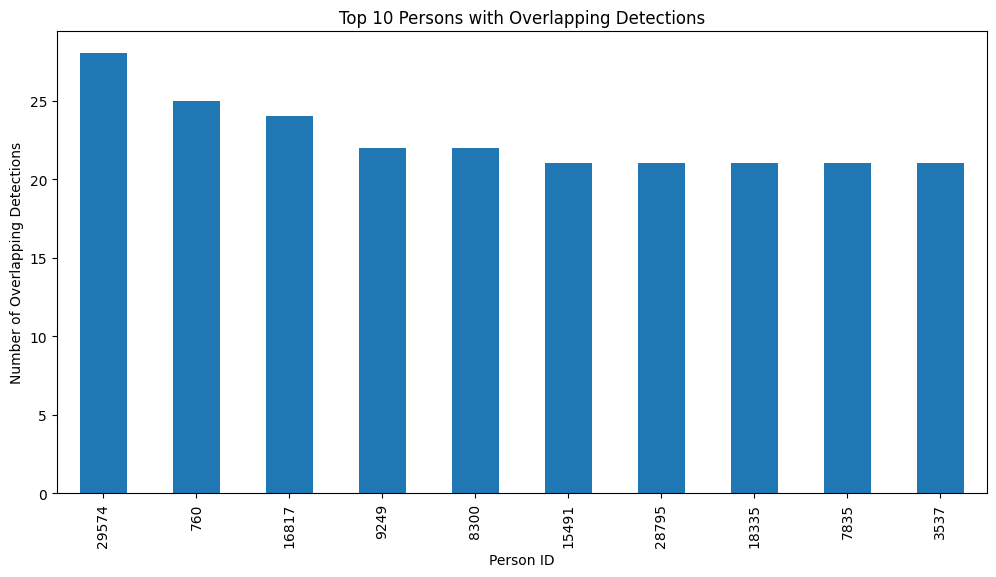

In [93]:
overlapping_dev = multiple_sensor_detections.groupby('person_id').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
overlapping_dev.plot(kind='bar')
plt.title('Top 10 Devices with Overlapping Detections')
plt.xlabel('Person ID')
plt.ylabel('Number of Overlapping Detections')
plt.show()

**Person ID 29574** is the most likely to go through overlapping zones

In [12]:
#find the tuple where signal strength is maximum
max_signal_strength = multiple_sensor_detections.loc[multiple_sensor_detections['signal_strength'].idxmax()]
max_overlapping_intensity = max(max_signal_strength['signal_strength'])

The overlapping area between sensors should have intensity value in the range of [0,0.33332342518089236]

Given this information we can estimate the maximum possible range of action of sensors.

Supposing a circular radius of the sensors, the maximum range can be calculated starting from the euclidean distance between two sensors minus the maximum distance value based on the maximum intensity in overlapping detections.

To estimate the distance based on intensity we can use some models and check the coverage area of these models.

$D_{max} = D(S,S') - D(I_{overlappingmax})$

Due to the nature of the signal we can estimate some models for $D(I)$

The first model proposed is based on an inverse law:

$D(I) = \frac{P}{I^n}$

where D is the distance, P is the proportionality factor associated to each type of devices, it will be supposed to be 1, I is the intensity and n is the exponent path loss that will be set to 1.6

In [13]:
distance_between_sensors = 16.63333
p = 1
n = 1.6
radius = distance_between_sensors - (1/(max_overlapping_intensity**n))
print('Estimated radius: ',radius)

Estimated radius:  10.829290570903243


Knowing the distribution could help in building accurate statistical models for predicting future values.

For instance, if the intensity values follow a lognormal distribution, predictive models can be tailored to incorporate this specific distribution.

Identifying deviations from the expected distribution can help in detecting anomalies. 

For example, if the majority of intensity values follow a specific distribution, any significant deviation might indicate an error or an unusual event.

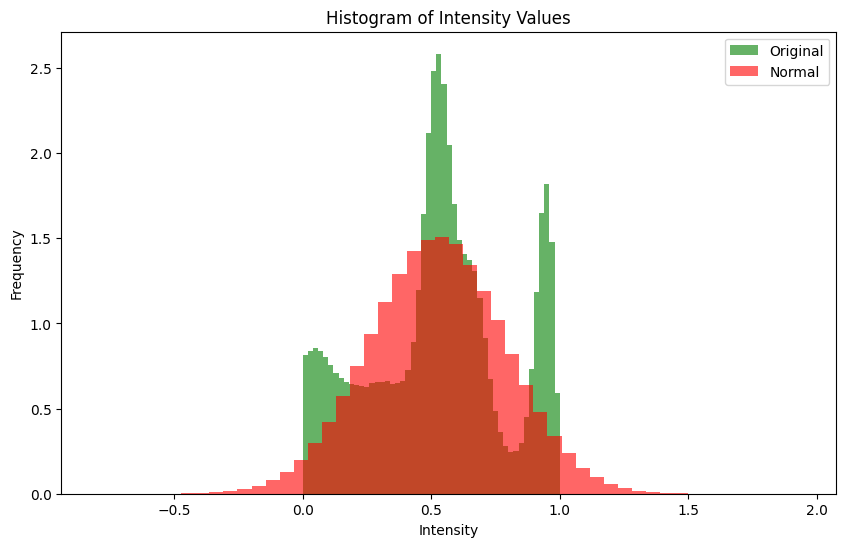

In [14]:
intensity_values_original = merged_df['signal_strength'].values
intensity_values_normal = np.random.normal(loc=signal_strength_summary['mean'], scale=signal_strength_summary['std'], size=int(signal_strength_summary['count']))


plt.figure(figsize=(10, 6))
plt.hist(intensity_values_original, bins=50, density=True, alpha=0.6, color='g')
plt.hist(intensity_values_normal, bins=50, density=True, alpha=0.6, color='r')
plt.title('Histogram of Intensity Values')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend(['Original', 'Normal'])
plt.show()

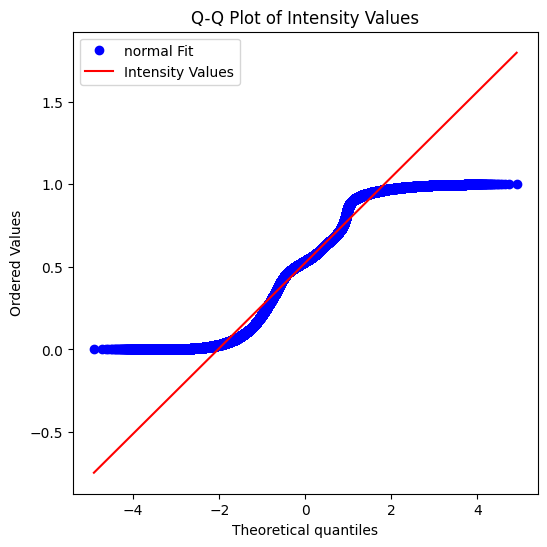

In [15]:
# Plot Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(intensity_values_original, dist="norm", plot=plt)
plt.title('Q-Q Plot of Intensity Values')
plt.legend(['normal Fit', 'Intensity Values'])
plt.show()

In [16]:
# Perform Shapiro-Wilk Test
shapiro_test = stats.shapiro(intensity_values_original[:5000])  # Using a subset for the test
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

# Perform Kolmogorov-Smirnov Test
ks_test = stats.kstest(intensity_values_original, 'norm', args=(signal_strength_summary['mean'], signal_strength_summary['std']))
print(f'Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}')

Shapiro-Wilk Test: Statistic=0.9530587553086268, p-value=2.4596452737244986e-37
Kolmogorov-Smirnov Test: Statistic=0.06533688371104412, p-value=0.0


The p-value of Shapiro-Wilk test is extremely low, which is much less than 0.05($\alpha$ value). This indicates that we can reject the null hypothesis that the data is normally distributed.

The p-value of Kolmogorov-Smirnov Test is 0.0, which again indicates that we can reject the null hypothesis that the data comes from a normal distribution.

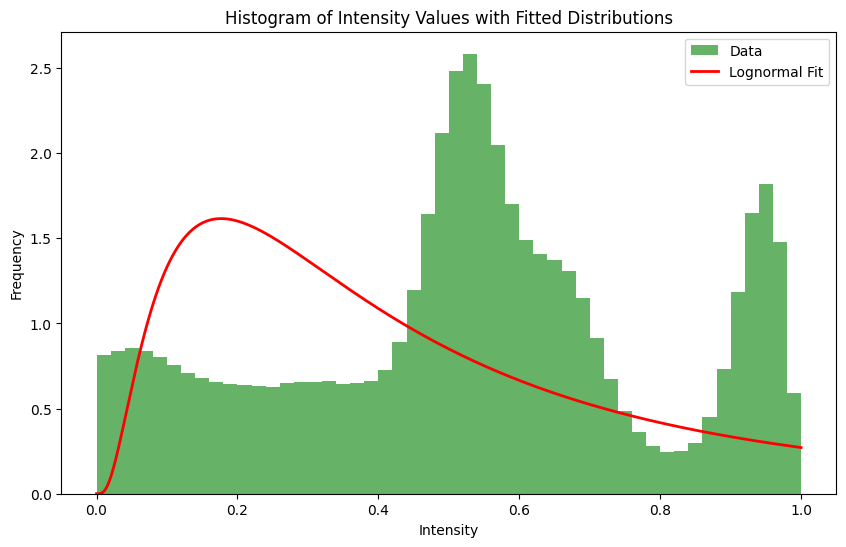

In [17]:
#Data for the lognormal distribution should be positive
intensity_values_original_pos = intensity_values_original+1e-6# Add a small value to avoid zero values

shape, loc, scale = stats.lognorm.fit(intensity_values_original_pos, floc=0)
lognorm_fitted = stats.lognorm(s=shape, loc=loc, scale=scale)

# Plot histogram with fitted lognormal
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(intensity_values_original_pos, bins=50, density=True, alpha=0.6, color='g', label='Data')

# Plot lognormal distribution
x = np.linspace(min(intensity_values_original_pos), max(intensity_values_original_pos), 1000)
plt.plot(x, lognorm_fitted.pdf(x), 'r-', lw=2, label='Lognormal Fit')

plt.title('Histogram of Intensity Values with Fitted Distributions')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

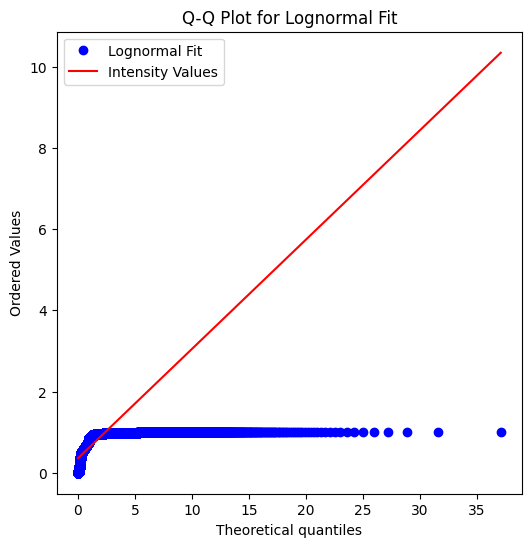

In [18]:
# Q-Q plot for Lognormal
plt.figure(figsize=(6, 6))
stats.probplot(intensity_values_original, dist=lognorm_fitted, plot=plt)
plt.title('Q-Q Plot for Lognormal Fit')
plt.legend(['Lognormal Fit', 'Intensity Values'])
plt.show()

Values and plots show that the intensity data cannot be modeled as a normal or lognormal distribution 

**Distribution of Sensors Positions in 2D coordinates**

<Figure size 1000x600 with 0 Axes>

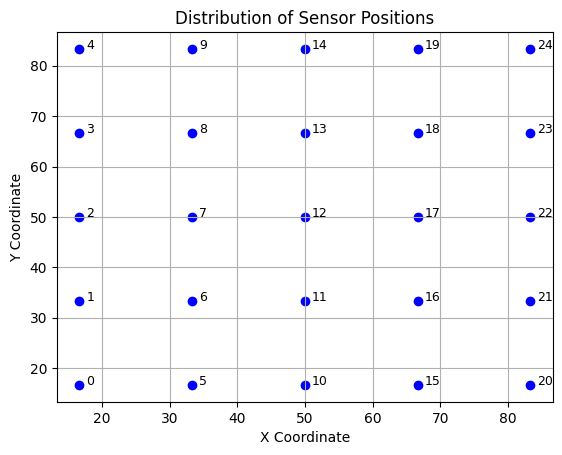

In [19]:
# Plot sensor positions
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
ax.scatter(sensor_map_df['x'], sensor_map_df['y'], c='blue', marker='o')
for i, txt in enumerate(sensor_map_df['sensor_id']):
    ax.annotate(str(sensor_map_df['sensor_id'][i]), (sensor_map_df['x'][i]+1, sensor_map_df['y'][i]), fontsize=9)
plt.title('Distribution of Sensor Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

**Trajectory analysis**

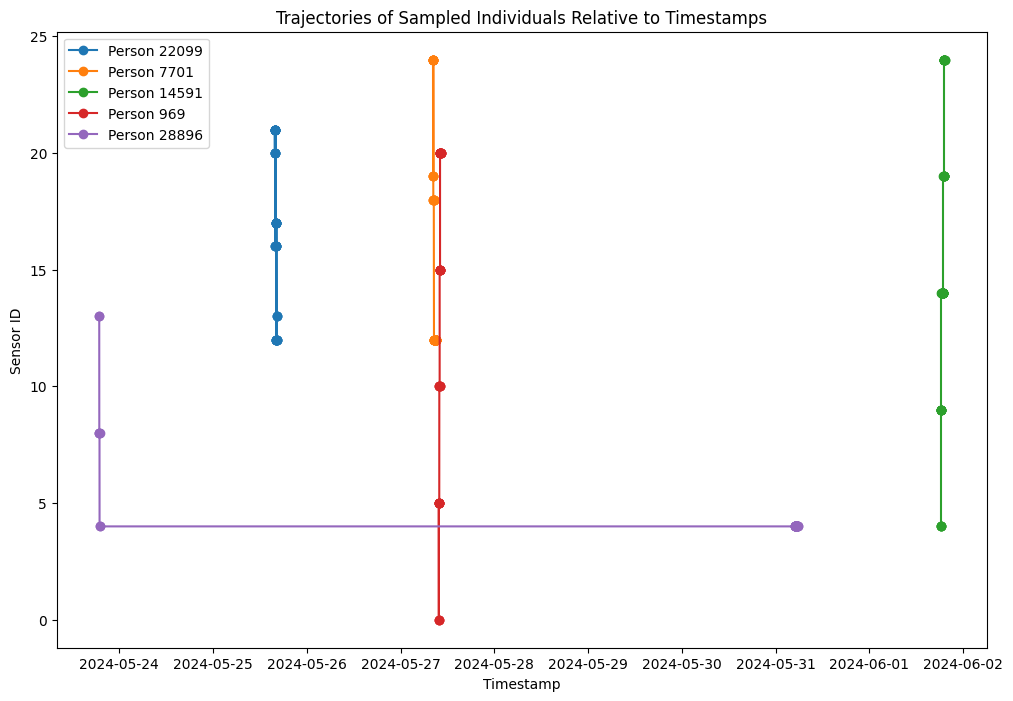

In [20]:
# Get a sample of unique person_ids
sample_person_ids = merged_df['person_id'].drop_duplicates().sample(5)
# Plot trajectories for each sampled person
plt.figure(figsize=(12, 8))
for person_id in sample_person_ids:
    person_data = merged_df[merged_df['person_id'] == person_id]
    person_data['timestamp'] = pd.to_datetime(person_data['timestamp'])
    person_data['sensor_id'] = person_data['sensor_id'].astype(int)
    plt.plot(person_data['timestamp'], person_data['sensor_id'], marker='o', linestyle='-', label=f'Person {person_id}')

plt.title('Trajectories of Sampled Individuals Relative to Timestamps')
plt.xlabel('Timestamp')
plt.ylabel('Sensor ID')
plt.legend()
plt.show()

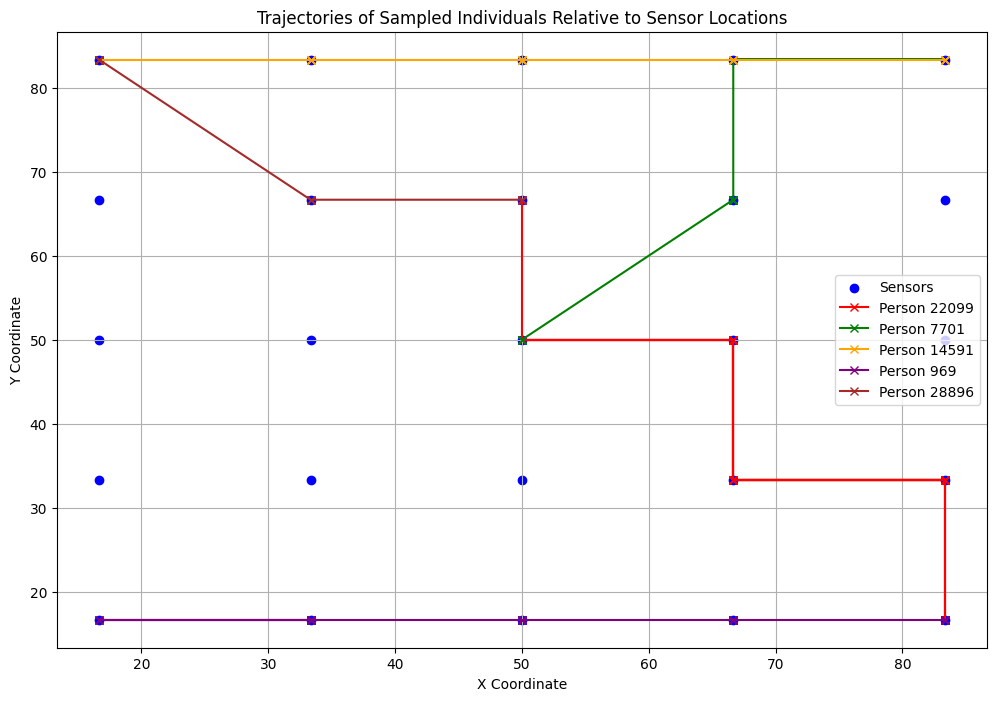

In [21]:
# Plot sensor positions again
plt.figure(figsize=(12, 8))
plt.scatter(sensor_map_df['x'], sensor_map_df['y'], c='blue', marker='o', label='Sensors')

# Plot trajectories on the grid
colors = ['red', 'green', 'orange', 'purple', 'brown']
for i, person_id in enumerate(sample_person_ids):
    person_data = merged_df[merged_df['person_id'] == person_id]
    plt.plot(person_data['x'], person_data['y'], marker='x', linestyle='-', color=colors[i], label=f'Person {person_id}')

plt.title('Trajectories of Sampled Individuals Relative to Sensor Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

**Coverage Analysis**

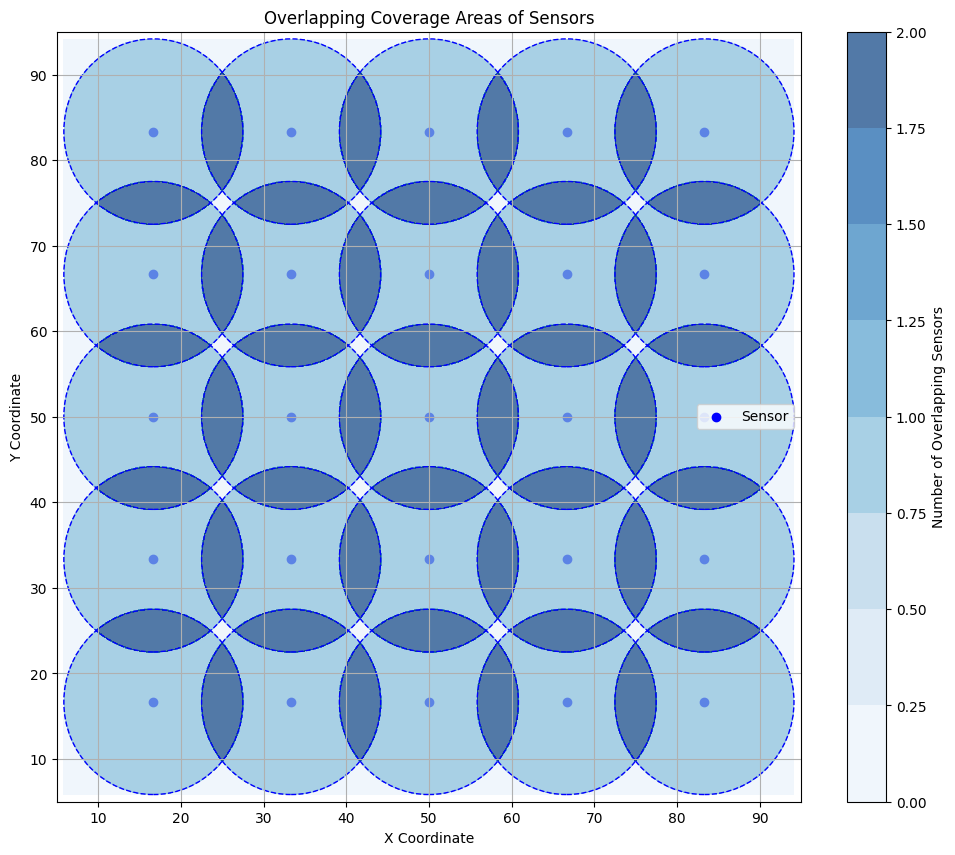

In [22]:
# Define the coverage radius
coverage_radius = radius

# Function to generate a fine grid of points
def generate_grid(x_min, x_max, y_min, y_max, grid_spacing):
    x = np.arange(x_min, x_max, grid_spacing)
    y = np.arange(y_min, y_max, grid_spacing)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

# Generate a fine grid of points
x_min, x_max = sensor_map_df['x'].min() - coverage_radius, sensor_map_df['x'].max() + coverage_radius
y_min, y_max = sensor_map_df['y'].min() - coverage_radius, sensor_map_df['y'].max() + coverage_radius
grid_spacing = 0.1  # Finer grid spacing
xx, yy = generate_grid(x_min, x_max, y_min, y_max, grid_spacing)
# Calculate coverage for each grid point
coverage = np.zeros(xx.shape)
for _, sensor in sensor_map_df.iterrows():
    distances = np.sqrt((xx - sensor['x'])**2 + (yy - sensor['y'])**2)
    coverage += distances < coverage_radius

# Plot the sensor positions
plt.figure(figsize=(12, 10))
plt.scatter(sensor_map_df['x'], sensor_map_df['y'], c='blue', marker='o', label='Sensor')

# Plot the overlapping coverage areas with a smoother contour plot
contour = plt.contourf(xx, yy, coverage, alpha=0.7, cmap='Blues')

# Plot circles to represent the coverage of each sensor
for _, sensor in sensor_map_df.iterrows():
    circle = Circle((sensor['x'], sensor['y']), coverage_radius, color='blue', fill=False, linestyle='--')
    plt.gca().add_patch(circle)

# Add a color bar to indicate the number of overlapping sensors
cbar = plt.colorbar(contour)
cbar.set_label('Number of Overlapping Sensors')
plt.xlim(5, 95)
plt.ylim(5, 95)
plt.title('Overlapping Coverage Areas of Sensors')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()


**Time Series Analysis**

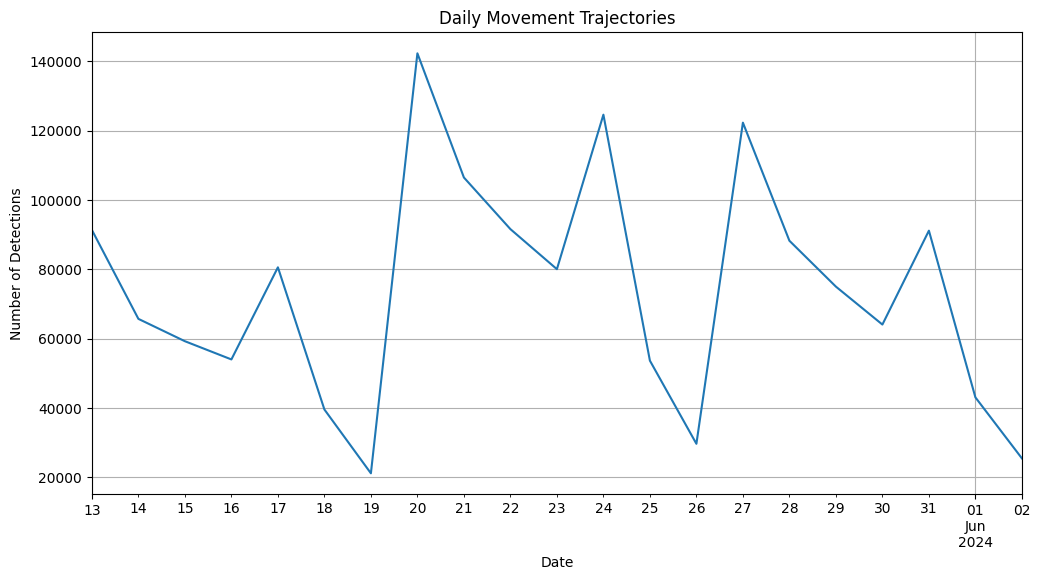

In [23]:
# Resample data to get daily counts
daily_counts = trajectories_df.resample('D', on='timestamp').size()

# Plot the daily counts
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Daily Movement Trajectories')
plt.xlabel('Date')
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()

Based on the visible trends in the provided time series graph:

The series is likely non-stationary due to the varying mean and variance over time.

It does not show clear evidence of seasonality within the provided period since the patterns do not repeat regularly over a fixed interval.

In order to determine if the time series is tationary or not we can perform an Augmented Dickey-Fuller (ADF) test

The ADF test has the following hypotheses:

**Null Hypothesis (H0)**: The time series has a unit root (i.e., it is non-stationary).

**Alternative Hypothesis (H1)**: The time series does not have a unit root (i.e., it is stationary).

If the p-value is less than the chosen significance level (e.g., 0.05), you reject the null hypothesis and conclude that the time series is stationary.
 Otherwise, you fail to reject the null hypothesis and conclude that the time series is non-stationary.

In [381]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(daily_counts)

# Print the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if adf_result[1] < 0.05:
    print("Reject the null hypothesis - The time series is stationary")
else:
    print("Fail to reject the null hypothesis - The time series is non-stationary")

ADF Statistic: -0.5323229482283324
p-value: 0.8855530649360119
Critical Values:
   1%: -4.137829282407408
   5%: -3.1549724074074077
   10%: -2.7144769444444443
Fail to reject the null hypothesis - The time series is non-stationary


<Figure size 2000x2000 with 0 Axes>

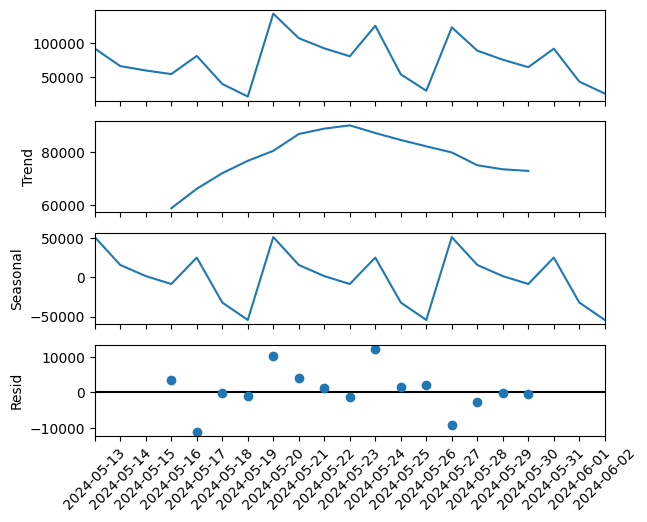

In [384]:

# Decompose the time series
decomposition = seasonal_decompose(daily_counts, model='additive')

# Plot the decomposed components
plt.figure(figsize=(20, 20))


decomposition.plot()
# Set the x-axis tick format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set the x-axis tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


Due to the non-stationarity nature of the daily count Time Series the forecasting could be made using ARIMA model

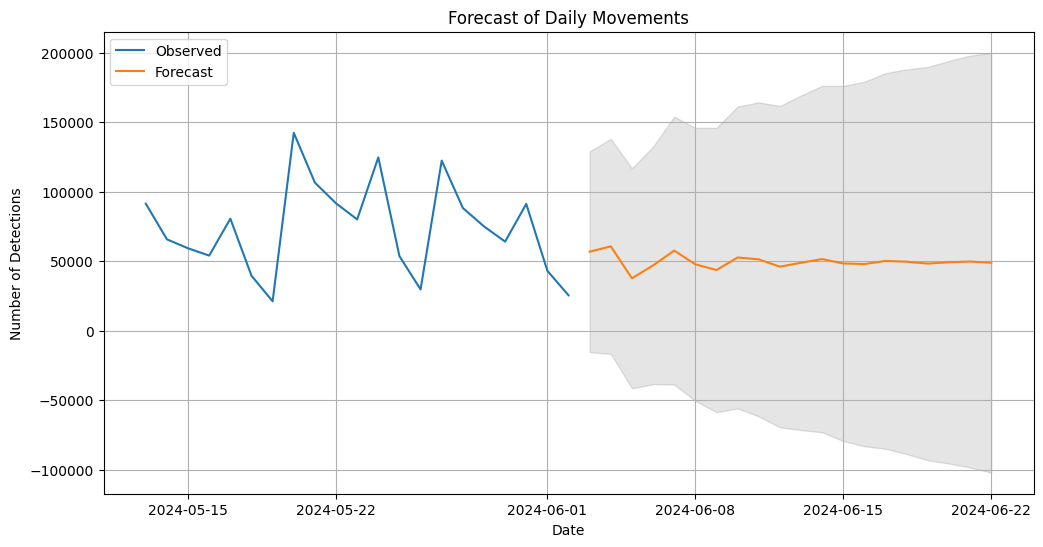

In [25]:
# Fit the ARIMA model
model = ARIMA(daily_counts, order=(5, 1, 0))
results = model.fit()

# Forecast the next 30 days
forecast = results.get_forecast(steps=20)
forecast_df = forecast.conf_int()
forecast_df['forecast'] = results.predict(start=forecast_df.index[0], end=forecast_df.index[-1])

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(daily_counts, label='Observed')
plt.plot(forecast_df['forecast'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['lower y'], forecast_df['upper y'], color='k', alpha=0.1)
plt.title('Forecast of Daily Movements')
plt.xlabel('Date')
plt.ylabel('Number of Detections')
plt.legend()
plt.grid(True)
plt.show()

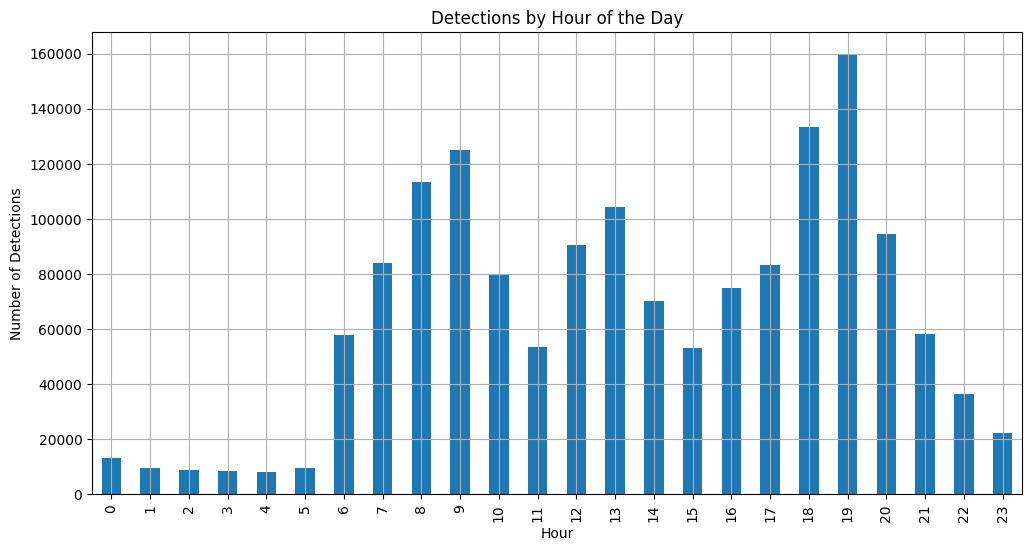

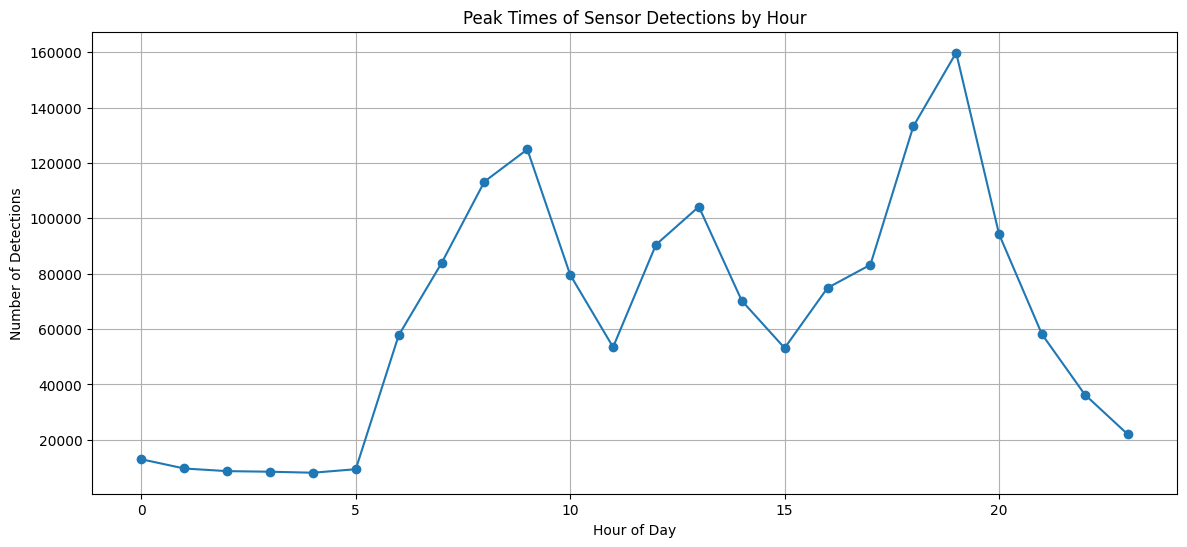

In [26]:
# Extract hour from timestamp
trajectories_df['hour'] = trajectories_df['timestamp'].dt.hour

# Group by hour and count detections
hourly_counts = trajectories_df.groupby('hour').size()

# Plot hourly counts
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar')
plt.title('Detections by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
plt.title('Peak Times of Sensor Detections by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()

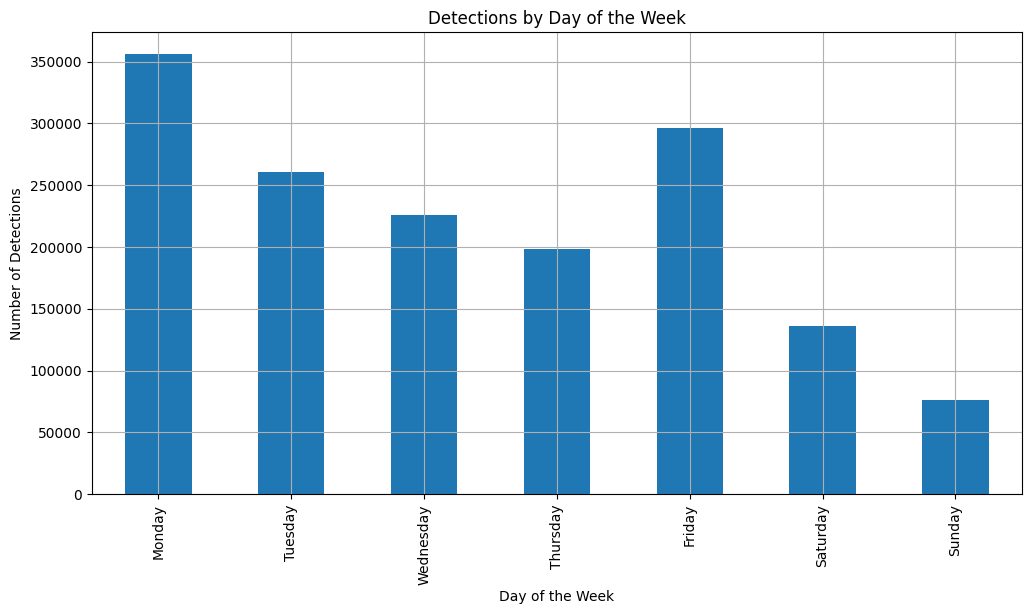

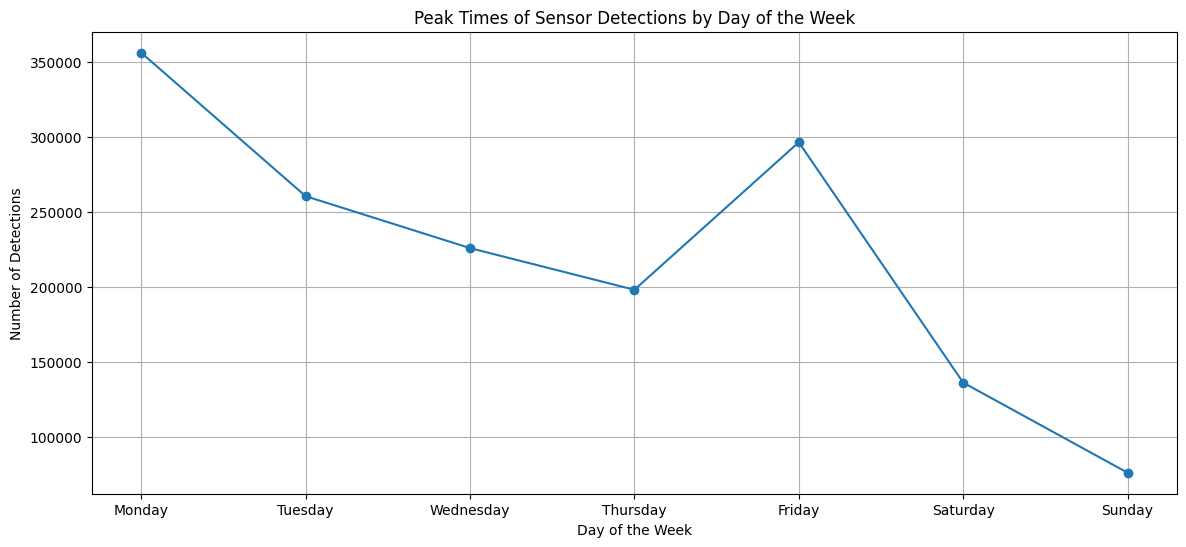

In [27]:
# Extract day of the week
trajectories_df['day_of_week'] = trajectories_df['timestamp'].dt.dayofweek

# Group by day of the week and count detections
weekly_counts = trajectories_df.groupby('day_of_week').size()

# Plot weekly counts
plt.figure(figsize=(12, 6))
weekly_counts.plot(kind='bar')
plt.title('Detections by Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks([0,1,2,3,4,5,6],["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.ylabel('Number of Detections')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
plt.title('Peak Times of Sensor Detections by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Detections')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)
plt.show()

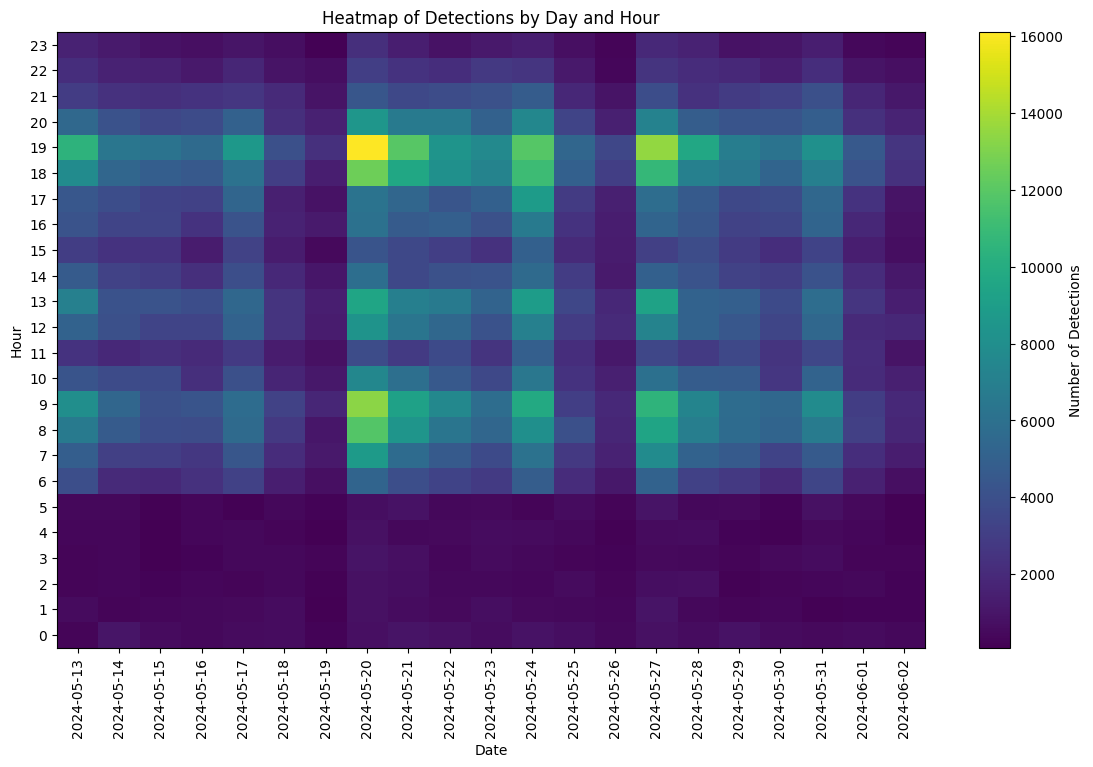

In [28]:
# Group by day and hour
daily_hourly_counts = trajectories_df.groupby([trajectories_df['timestamp'].dt.date, trajectories_df['timestamp'].dt.hour]).size().unstack(fill_value=0)

# Plot heatmap of daily and hourly counts
plt.figure(figsize=(14, 8))
plt.imshow(daily_hourly_counts.T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Number of Detections')
plt.title('Heatmap of Detections by Day and Hour')
plt.xlabel('Date')
plt.ylabel('Hour')
plt.xticks(range(len(daily_hourly_counts.index)), daily_hourly_counts.index, rotation=90)
plt.yticks(range(24), range(24))
plt.show()

**Spatial Analysis**

The heatmap generated below describes the densities of the number of detections in the grid.

The area has been divided into a 5x5 grid in which every split represent an area covered by a sensor, the sensors ID related to the area can be determined by row+(column*5).

For example the first sensor will be in the first column and first row, 0 + 0*5 = 0

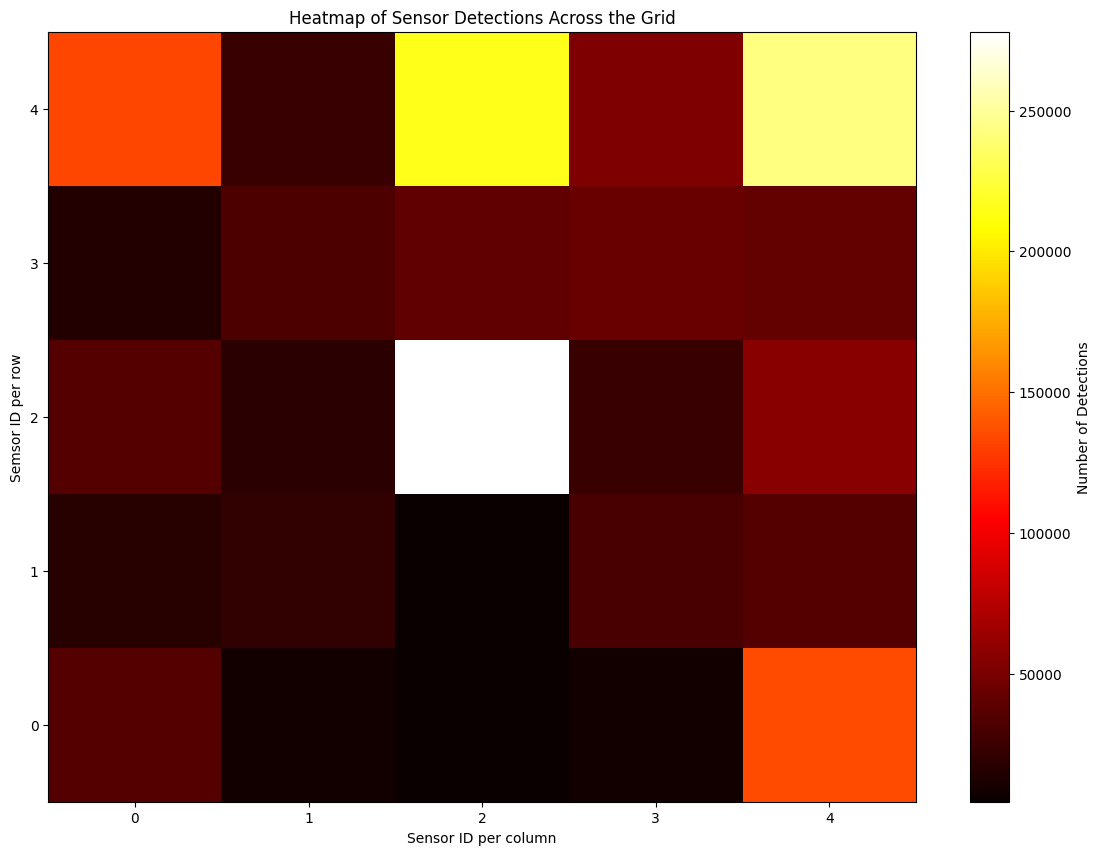

In [29]:
# Create a heatmap of detections across the sensor grid
heatmap_data = merged_df.pivot_table(index='y', columns='x', values='sensor_id', aggfunc='count', fill_value=0)

plt.figure(figsize=(14, 10))
plt.title('Heatmap of Sensor Detections Across the Grid')
plt.xlabel('Sensor ID per column')
plt.ylabel('Semsor ID per row')
plt.xticks(range(len(heatmap_data.index)), [0,1,2,3,4])
plt.yticks(range(len(heatmap_data.columns)), [0,1,2,3,4])
plt.imshow(heatmap_data, aspect='auto', cmap='hot', origin='lower')
plt.colorbar(label='Number of Detections')
plt.show()

Trajectory 1: 24->19->24->19->14->19->14
Trajectory 2: 22->17->22->17->12->17->12
Trajectory 3: 20->21->22->23->24
Trajectory 4: 0->1->2->3->4
Trajectory 5: 24->19->14->19->14
Trajectory 6: 20->16->12
Trajectory 7: 22->23->24
Trajectory 8: 24
Trajectory 9: 22->17->22->17->12->17->12->17->12
Trajectory 10: 4->9->14->19->24


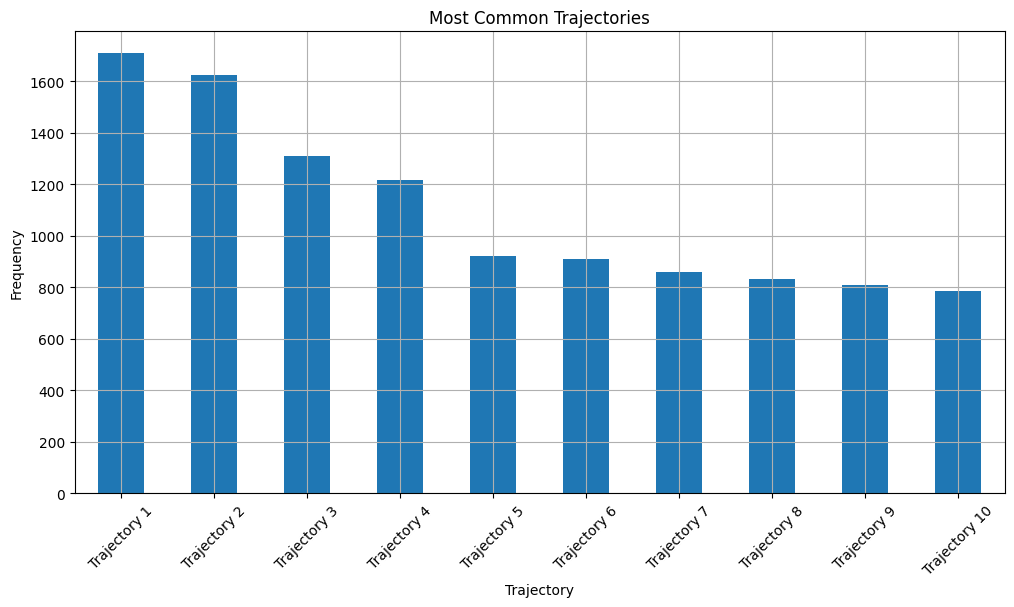

In [33]:
# Sort by person_id and timestamp
merged_df = merged_df.sort_values(by=['person_id', 'timestamp'])

# Remove stationary points where sensor_id does not change
merged_df['prev_sensor_id'] = merged_df.groupby('person_id')['sensor_id'].shift(1)
filtered_df = merged_df[merged_df['sensor_id'] != merged_df['prev_sensor_id']]

# Create a trajectory string for each person
filtered_df['trajectory'] = filtered_df.groupby('person_id')['sensor_id'].transform(lambda x: '->'.join(x.astype(str)))

# Identify the most common trajectories
common_trajectories = filtered_df['trajectory'].value_counts().head(10)
for i in range(10):
    print(f'Trajectory {i+1}:',common_trajectories.index[i])
    
# Rename the trajectories to 'Trajectory 1', 'Trajectory 2', etc.
common_trajectories.index = [f'Trajectory {i+1}' for i in range(len(common_trajectories))]


# Visualize the most common trajectories
plt.figure(figsize=(12, 6))
common_trajectories.plot(kind='bar')
plt.title('Most Common Trajectories')
plt.xlabel('Trajectory')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)


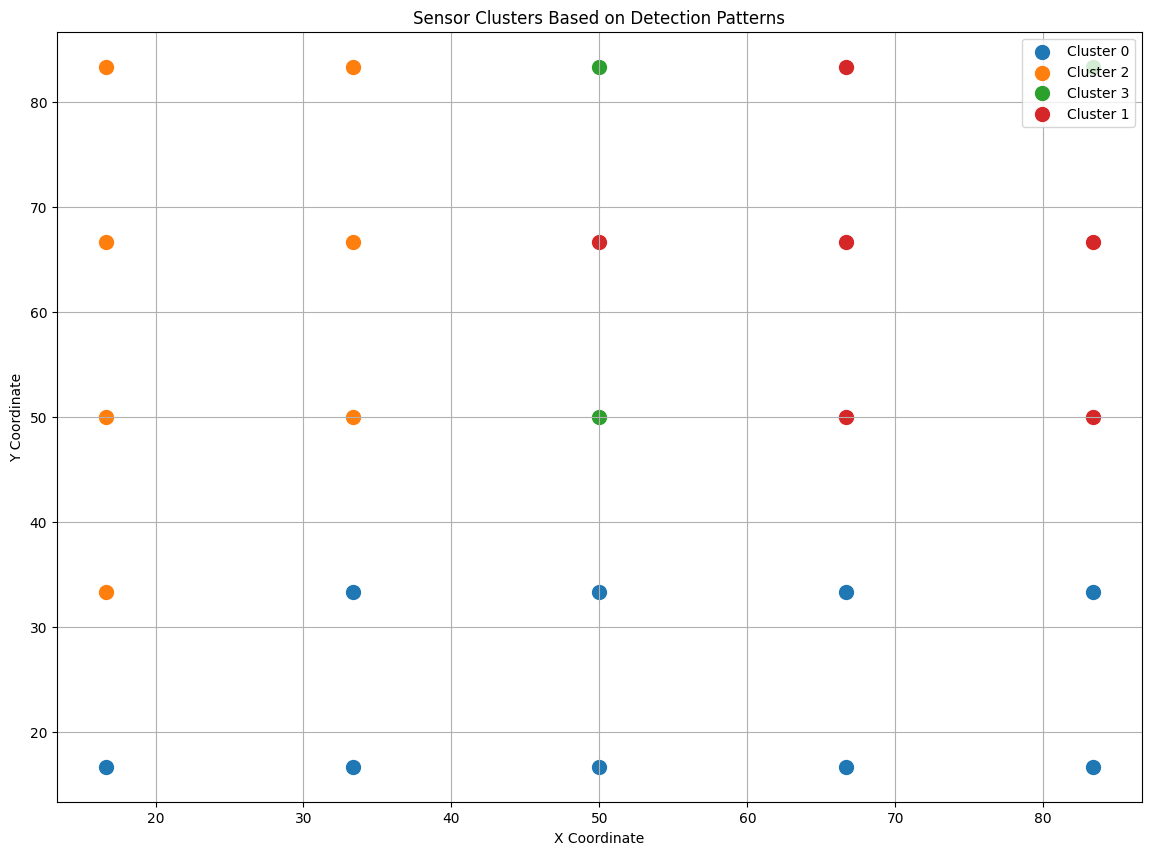

In [34]:
# Aggregate sensor detection counts by sensor_id
sensor_detection_counts = merged_df.groupby('sensor_id').size().reset_index(name='detections')

# Merge detection counts with sensor coordinates
sensor_features = pd.merge(sensor_detection_counts, sensor_map_df, on='sensor_id')

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sensor_features[['detections', 'x', 'y']])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=1)
sensor_features['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters on the sensor grid
plt.figure(figsize=(14, 10))
for cluster in sensor_features['cluster'].unique():
    cluster_data = sensor_features[sensor_features['cluster'] == cluster]
    plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}', s=100)

plt.title('Sensor Clusters Based on Detection Patterns')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
sensor_features.groupby('cluster')['detections'].mean()

cluster
0     31406.222222
1     42858.833333
2     39003.142857
3    245672.666667
Name: detections, dtype: float64

In [ ]:
sensor_features.groupby('cluster').size()

cluster
0    9
1    6
2    7
3    3
dtype: int64

**Insights**

Cluster 0: Sensors with moderate detection counts.

Cluster 1: Sensors with lower detection counts, often located in the same row.

Cluster 2: Sensors with high detection counts, spread across different rows.

Cluster 3: Sensors with very high detection counts, likely located in high-traffic areas.

**Features calculation**

In [36]:
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])
merged_df['date'] = merged_df['timestamp'].dt.date

In [37]:
merged_df = merged_df.sort_values(by=['person_id', 'date', 'timestamp'])

In [80]:
# Get the previous x coordinate
merged_df['prev_x'] = merged_df.groupby(['person_id', 'date'])['x'].shift(1)
# Get the previous y coordinate
merged_df['prev_y'] = merged_df.groupby(['person_id', 'date'])['y'].shift(1)
# Get the next x coordinate
merged_df['next_x'] = merged_df.groupby(['person_id', 'date'])['x'].shift(-1)
# Get the next y coordinate
merged_df['next_y'] = merged_df.groupby(['person_id', 'date'])['y'].shift(-1)

# Calculate the time difference between consecutive points
merged_df['prev_timestamp'] = merged_df.groupby(['person_id', 'date'])['timestamp'].shift(1)

#Calculate the direction of movement
def calculate_direction(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

merged_df['direction'] = merged_df.apply(lambda row: calculate_direction(row['prev_x'], row['prev_y'], row['x'], row['y']) if pd.notnull(row['prev_x']) and pd.notnull(row['prev_y']) else np.nan, axis=1)
# Calculate the direction of movement for the next point
merged_df['next_direction'] = merged_df.apply(lambda row: calculate_direction(row['x'], row['y'], row['x'], row['y']) if pd.notnull(row['prev_x']) and pd.notnull(row['prev_y']) else np.nan, axis=1)

# Calculate the distance between consecutive points
merged_df['strength_diff'] = merged_df.groupby(by=['person_id','sensor_id','date'])['signal_strength'].diff()
merged_df['prev_sensor_id'] = merged_df.groupby(['person_id', 'date'])['sensor_id'].shift(1)
merged_df['next_sensor_id'] = merged_df.groupby(['person_id', 'date'])['sensor_id'].shift(-1)


In [85]:
features = merged_df[['timestamp', 'person_id', 'signal_strength', 'sensor_id', 'prev_sensor_id', 'next_sensor_id', 'direction', 'next_direction', 'strength_diff']]
features.sort_values(by=['person_id', 'timestamp'], inplace=True)
features.dropna(inplace=True)
features['prev_sensor_id'] = features['prev_sensor_id'].astype(int)
features['next_sensor_id'] = features['next_sensor_id'].astype(int)

In [288]:
X = features[['signal_strength', 'person_id', 'sensor_id', 'prev_sensor_id', 'direction', 'next_direction', 'strength_diff']]
y = features[['next_sensor_id']]

In [289]:
#Make the categorical variables dummy variables
X = pd.get_dummies(X, columns=['sensor_id', 'prev_sensor_id'])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=20, random_state=42)

# Train the model
model.fit(X_train, y_train)

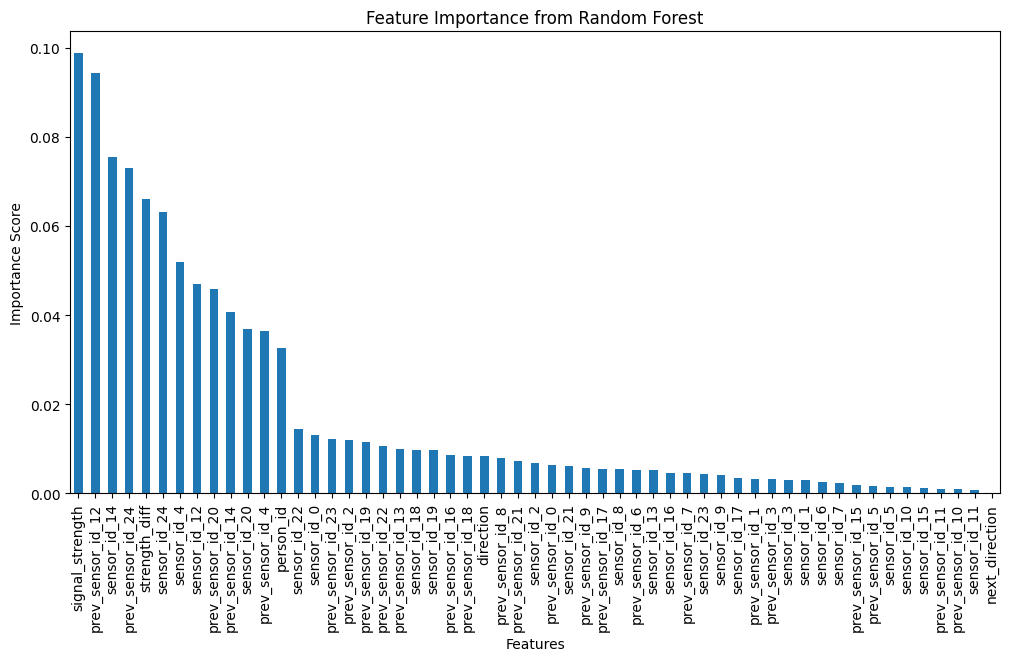

In [391]:
importances = model.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
forest_importances.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [273]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# Calculate precision
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
# Calculate recall
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")

Accuracy: 0.9291999689035157
Precision: 0.9285355179290307
Recall: 0.9291999689035157


In [299]:
def revert_one_hot_encoding(df, original_columns):
    reverted_df = df.copy()
    for col in original_columns:
        one_hot_cols = [c for c in df.columns if c.startswith(col + '_')]
        reverted_df[col] = df[one_hot_cols].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
        reverted_df = reverted_df.drop(columns=one_hot_cols)
    return reverted_df

In [389]:
# Display a few predictions
predictions_df = X_test.copy()
predictions_df['predicted_next_sensor_id'] = y_pred
predictions_df['next_sensor_id'] = y_test.values

# List of original categorical columns that were one-hot encoded
original_categorical_columns = ['sensor_id', 'prev_sensor_id']

# Revert the one-hot encoding
predictions_df = revert_one_hot_encoding(predictions_df, original_categorical_columns)
predictions_df.sort_values(by=['person_id'], inplace=True)
predictions_df['diff_sensor'] = abs(predictions_df['next_sensor_id'] - predictions_df['sensor_id'])
predictions_df['diff_sensor_predicted'] = abs(predictions_df['predicted_next_sensor_id'] - predictions_df['sensor_id'])

predictions_df[['next_sensor_id', 'predicted_next_sensor_id']].head(10)

,next_sensor_id,predicted_next_sensor_id
747242,23,22
215242,24,24
674362,20,20
672758,24,24
747686,24,24
215577,24,24
747799,24,24
674169,20,20
746879,21,21
674461,20,20


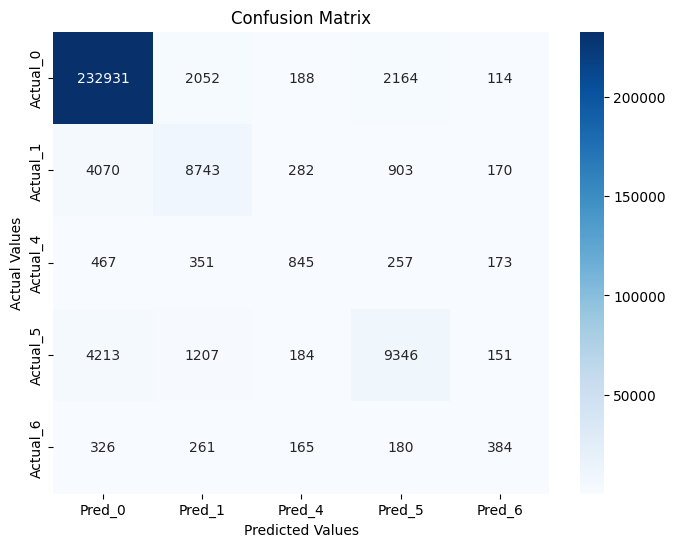

In [276]:
# Get the true labels and predicted labels
y_true = predictions_df['diff_sensor']
y_pred = predictions_df['diff_sensor_predicted']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm_df = pd.DataFrame(cm, index=['Actual_0', 'Actual_1', 'Actual_4', 'Actual_5', 'Actual_6'], columns=['Pred_0', 'Pred_1', 'Pred_4', 'Pred_5', 'Pred_6'])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [277]:
# Calculate TP, FP, FN, TN
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Precision, Recall and Accuracy
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

classes = [0, 1, 4, 5, 6]

for i, value in enumerate(classes):
    print(f'Sensor_diff {value}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'Accuracy: {accuracy[i]}')

# Average Precision, Recall, and Accuracy
# Weighted by the support
support = cm.sum(axis=1)
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
overall_accuracy = np.sum(TP) / np.sum(cm)

print(f'Weighted Precision: {weighted_precision}')
print(f'Weighted Recall: {weighted_recall}')
print(f'Accuracy: {overall_accuracy}')

Sensor_diff 0:
Precision: 0.9624969525674877
Recall: 0.9809727562550274
Accuracy: 0.9496755229947396
Sensor_diff 1:
Precision: 0.693118756936737
Recall: 0.6170948616600791
Accuracy: 0.9655865574340958
Sensor_diff 4:
Precision: 0.5078125
Recall: 0.40372670807453415
Accuracy: 0.9923480436979643
Sensor_diff 5:
Precision: 0.7273151750972763
Recall: 0.6188994106350573
Accuracy: 0.9657235300432759
Sensor_diff 6:
Precision: 0.3870967741935484
Recall: 0.2917933130699088
Accuracy: 0.9942989778881786
Weighted Precision: 0.9288945674255433
Weighted Recall: 0.9338163160291271
Accuracy: 0.9338163160291271


**Evaluation without stationary trajectories** (excluding sensor_diff 0)

In [278]:
#Delete the 0th row and column
cm_nozero = cm[1:, 1:]

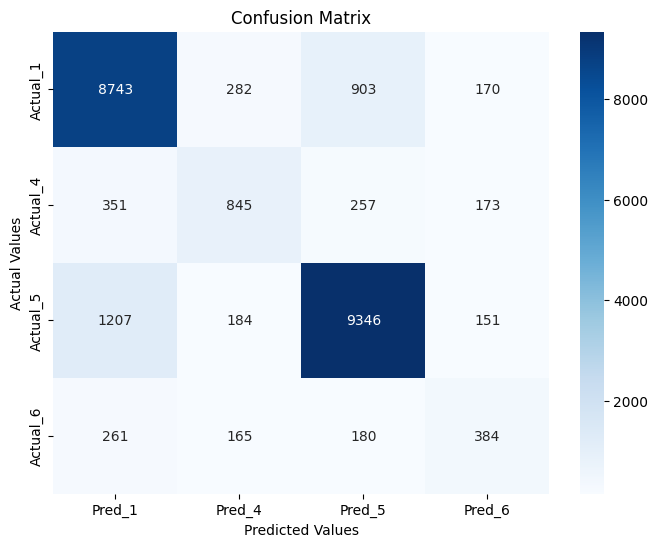

In [279]:
cm_nozero_df = pd.DataFrame(cm_nozero, index=['Actual_1', 'Actual_4', 'Actual_5', 'Actual_6'], columns=['Pred_1', 'Pred_4', 'Pred_5', 'Pred_6'])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nozero_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [280]:
TP = np.diag(cm_nozero)
FP = cm_nozero.sum(axis=0) - TP
FN = cm_nozero.sum(axis=1) - TP
TN = cm_nozero.sum() - (FP + FN + TP)

# Precision, Recall and Accuracy for each class
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

classes = [1, 4, 5, 6]

for i, value in enumerate(classes):
    print(f'Sensor_diff {value}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'Accuracy: {accuracy[i]}')

# Average Precision, Recall, and Accuracy
# Weighted by the support (number of true instances for each class)
support = cm_nozero.sum(axis=1)
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
overall_accuracy = np.sum(TP) / np.sum(cm_nozero)

print(f'Weighted Precision (excluding class 0): {weighted_precision}')
print(f'Weighted Recall (excluding class 0): {weighted_recall}')
print(f'Accuracy (excluding class 0): {overall_accuracy}')

Sensor_diff 1:
Precision: 0.8277788297670896
Recall: 0.8658150128738364
Accuracy: 0.8655198711973562
Sensor_diff 4:
Precision: 0.5724932249322493
Recall: 0.519680196801968
Accuracy: 0.9401745614778408
Sensor_diff 5:
Precision: 0.8746022833614074
Recall: 0.8583761939750184
Accuracy: 0.8778917040928735
Sensor_diff 6:
Precision: 0.43735763097949887
Recall: 0.3878787878787879
Accuracy: 0.9533937801881196
Weighted Precision (excluding class 0): 0.8154155716734436
Weighted Recall (excluding class 0): 0.818489958478095
Accuracy (excluding class 0): 0.818489958478095


When $\mid{Sensor_{ID}-NextSensor_{ID}\mid} = 4$ or $\mid{Sensor_{ID}-NextSensor_{ID}\mid} = 6$ the trajectory is diagonal, these trajectories are most likely to go through a not covered zone.

In [315]:
TP_dark = TP[1]+TP[3]
FP_dark = FP[1]+FP[3]
FN_dark = FN[1]+FN[3]
TN_dark = TN[1]+TN[3]


precision_dark = TP_dark / (TP_dark + FP_dark)
recall_dark = TP_dark / (TP_dark + FN_dark)
accuracy_dark = (TP_dark + TN_dark) / (TP_dark + TN_dark + FP_dark + FN_dark)

print(f'Sensor_diff 4 and 6:')
print(f'Precision: {precision_dark}')
print(f'Recall: {recall_dark}')
print(f'Accuracy: {accuracy_dark}')

Sensor_diff 4 and 6:
Precision: 0.5220900594732371
Recall: 0.46980122324159024
Accuracy: 0.9467841708329803


Values of precision and recall are low and this model should be improved with a better choice of the features.

In [ ]:
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gb.fit(X_train, y_train)

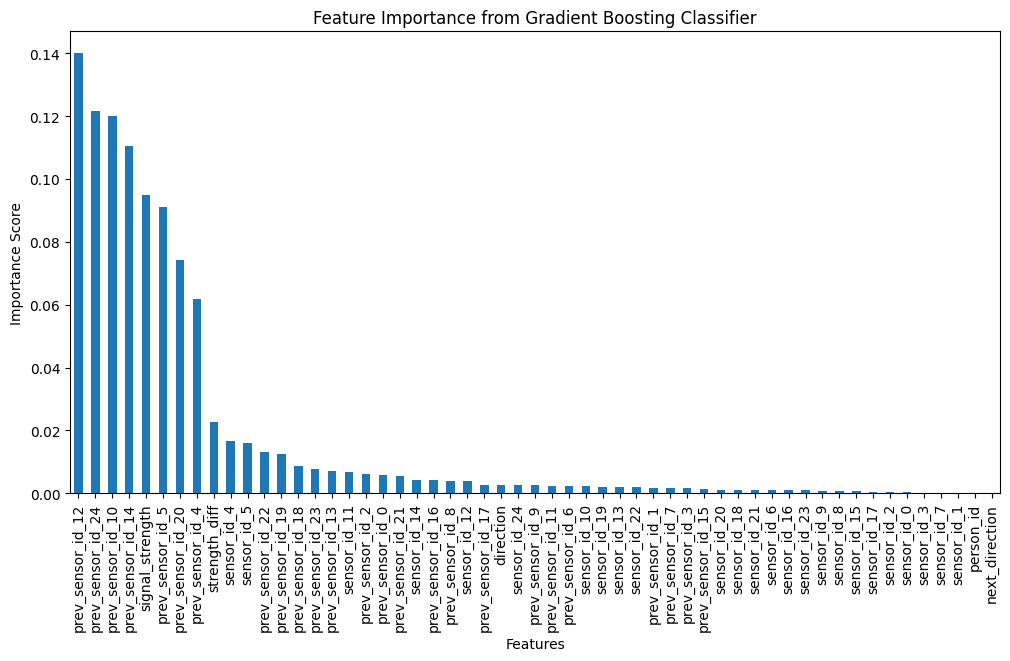

In [390]:
importances = model_gb.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
forest_importances.plot(kind='bar')
plt.title('Feature Importance from Gradient Boosting Classifier')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

In [361]:
# Predict on the test set
y_pred_gb = model_gb.predict(X_test)
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
# Calculate precision
print(f"Precision: {precision_score(y_test, y_pred_gb, average='weighted')}")
# Calculate recall
print(f"Recall: {recall_score(y_test, y_pred_gb, average='weighted')}")

Accuracy: 0.9270602346303776
Precision: 0.9252564103387555
Recall: 0.9270602346303776


In [362]:
# Display a few predictions
predictions_gb_df = X_test.copy()
predictions_gb_df['predicted_next_sensor_id'] = y_pred_gb
predictions_gb_df['next_sensor_id'] = y_test.values

# List of original categorical columns that were one-hot encoded
original_categorical_columns_gb = ['sensor_id', 'prev_sensor_id']

# Revert the one-hot encoding
predictions_gb_df = revert_one_hot_encoding(predictions_gb_df, original_categorical_columns_gb)
predictions_gb_df.sort_values(by=['person_id'], inplace=True)
predictions_gb_df['diff_sensor'] = abs(predictions_gb_df['next_sensor_id'] - predictions_gb_df['sensor_id'])
predictions_gb_df['diff_sensor_predicted'] = abs(predictions_gb_df['predicted_next_sensor_id'] - predictions_gb_df['sensor_id'])

Deleting prediction out of range

In [363]:
predictions_gb_df = predictions_gb_df[predictions_gb_df['diff_sensor_predicted'] <= 6]
predictions_gb_df = predictions_gb_df[predictions_gb_df['diff_sensor_predicted'] != 2]
predictions_gb_df = predictions_gb_df[predictions_gb_df['diff_sensor_predicted'] != 3]


In [364]:
predictions_gb_df['diff_sensor_predicted'].value_counts()

diff_sensor_predicted
0    242505
1     12995
5     12591
4      1021
6       849
Name: count, dtype: int64

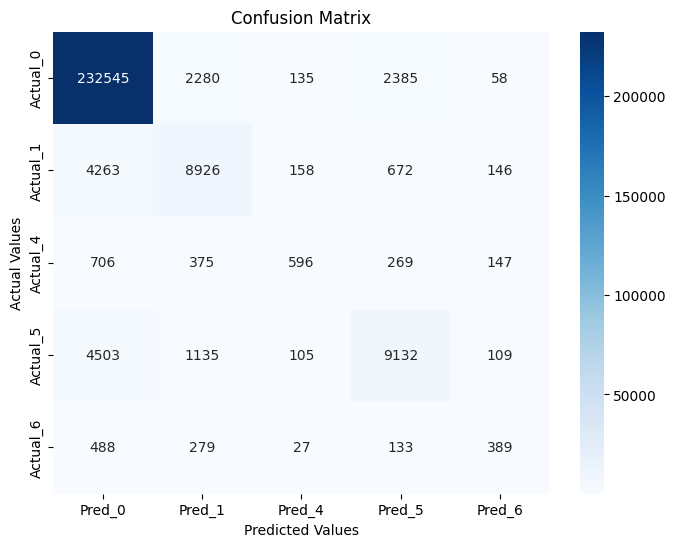

In [365]:
# Get the true labels and predicted labels
y_true_gb = predictions_gb_df['diff_sensor']
y_pred_gb = predictions_gb_df['diff_sensor_predicted']

# Create the confusion matrix
cm_gb = confusion_matrix(y_true_gb, y_pred_gb)

cm_gb_df = pd.DataFrame(cm_gb, index=['Actual_0', 'Actual_1', 'Actual_4', 'Actual_5', 'Actual_6'], columns=['Pred_0', 'Pred_1', 'Pred_4', 'Pred_5', 'Pred_6'])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [366]:
# Calculate TP, FP, FN, TN
TP_gb = np.diag(cm_gb)
FP_gb = cm_gb.sum(axis=0) - TP_gb
FN_gb = cm_gb.sum(axis=1) - TP_gb
TN_gb = cm_gb.sum() - (FP_gb + FN_gb + TP_gb)

# Precision, Recall and Accuracy
precision_gb = TP_gb / (TP_gb + FP_gb)
recall_gb = TP_gb / (TP_gb + FN_gb)
accuracy_gb = (TP_gb + TN_gb) / (TP_gb + TN_gb + FP_gb + FN_gb)

classes = [0, 1, 4, 5, 6]

for i, value in enumerate(classes):
    print(f'Sensor_diff {value}:')
    print(f'Precision: {precision_gb[i]}')
    print(f'Recall: {recall_gb[i]}')
    print(f'Accuracy: {accuracy_gb[i]}')

# Average Precision, Recall, and Accuracy
# Weighted by the support
support = cm_gb.sum(axis=1)

print(f'Weighted Precision: { np.sum(precision_gb * support) / np.sum(support)}')
print(f'Weighted Recall: {np.sum(recall_gb * support) / np.sum(support)}')
print(f'Accuracy: {np.sum(TP_gb) / np.sum(cm_gb)}')

Sensor_diff 0:
Precision: 0.9589286818828477
Recall: 0.9795369055993395
Accuracy: 0.9451105900481922
Sensor_diff 1:
Precision: 0.686879569065025
Recall: 0.6301447229085775
Accuracy: 0.9655209456180708
Sensor_diff 4:
Precision: 0.5837414299706171
Recall: 0.28475871954132825
Accuracy: 0.9928804531024852
Sensor_diff 5:
Precision: 0.7252799618775315
Recall: 0.6094500800854245
Accuracy: 0.9655098329017895
Sensor_diff 6:
Precision: 0.4581861012956419
Recall: 0.29559270516717323
Accuracy: 0.9948622208393064
Weighted Precision: 0.9263357804714247
Weighted Recall: 0.931942021254922
Accuracy: 0.931942021254922


In [368]:
#Delete the 0th row and column
cm_nozero_gb = cm_gb[1:, 1:]

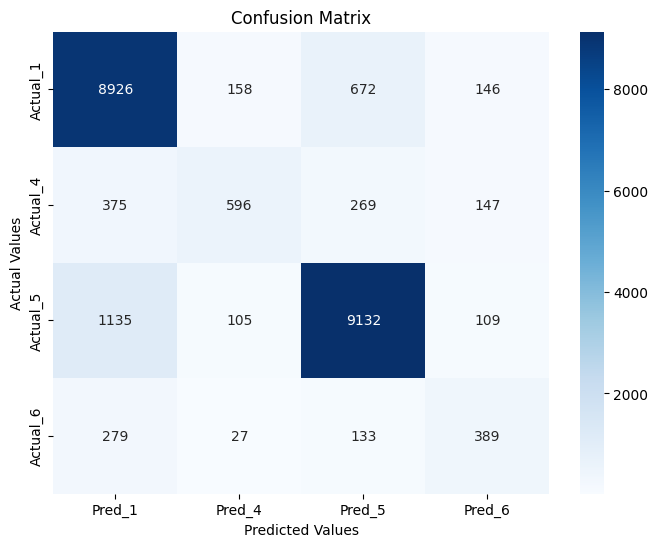

In [369]:
cm_nozero_gb_df = pd.DataFrame(cm_nozero_gb, index=['Actual_1', 'Actual_4', 'Actual_5', 'Actual_6'], columns=['Pred_1', 'Pred_4', 'Pred_5', 'Pred_6'])

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nozero_gb_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [371]:
# Calculate TP, FP, FN, TN
TP_gb = np.diag(cm_nozero_gb)
FP_gb = cm_nozero_gb.sum(axis=0) - TP_gb
FN_gb = cm_nozero_gb.sum(axis=1) - TP_gb
TN_gb = cm_nozero_gb.sum() - (FP_gb + FN_gb + TP_gb)

# Precision, Recall and Accuracy
precision_gb = TP_gb / (TP_gb + FP_gb)
recall_gb = TP_gb / (TP_gb + FN_gb)
accuracy_gb = (TP_gb + TN_gb) / (TP_gb + TN_gb + FP_gb + FN_gb)

classes = [1, 4, 5, 6]

for i, value in enumerate(classes):
    print(f'Sensor_diff {value}:')
    print(f'Precision: {precision_gb[i]}')
    print(f'Recall: {recall_gb[i]}')
    print(f'Accuracy: {accuracy_gb[i]}')

# Average Precision, Recall, and Accuracy
# Weighted by the support
support = cm_nozero_gb.sum(axis=1)

print(f'Weighted Precision: { np.sum(precision_gb * support) / np.sum(support)}')
print(f'Weighted Recall: {np.sum(recall_gb * support) / np.sum(support)}')
print(f'Accuracy: {np.sum(TP_gb) / np.sum(cm_gb)}')

Sensor_diff 1:
Precision: 0.833037797480168
Recall: 0.9014340537265199
Accuracy: 0.8776440392955128
Sensor_diff 4:
Precision: 0.672686230248307
Recall: 0.4297043979812545
Accuracy: 0.9521639083104699
Sensor_diff 5:
Precision: 0.8947677836566725
Recall: 0.8712909073561683
Accuracy: 0.8927781219576953
Sensor_diff 6:
Precision: 0.4917825537294564
Recall: 0.46980676328502413
Accuracy: 0.962784317196212
Weighted Precision: 0.8393226465614924
Weighted Recall: 0.8426851933799451
Accuracy: 0.07053981871455507


In [372]:
TP_dark_gb = TP_gb[1]+TP_gb[3]
FP_dark_gb = FP_gb[1]+FP_gb[3]
FN_dark_gb = FN_gb[1]+FN_gb[3]
TN_dark_gb = TN_gb[1]+TN_gb[3]

precision_dark_gb = TP_dark_gb / (TP_dark_gb + FP_dark_gb)
recall_dark_gb = TP_dark_gb / (TP_dark_gb + FN_dark_gb)
accuracy_dark_gb = (TP_dark_gb + TN_dark_gb) / (TP_dark_gb + TN_dark_gb + FP_dark_gb + FN_dark_gb)

print(f'Sensor_diff 4 and 6:')
print(f'Precision: {precision_dark_gb}')
print(f'Recall: {recall_dark_gb}')
print(f'Accuracy: {accuracy_dark_gb}')

Sensor_diff 4 and 6:
Precision: 0.5873583780560525
Recall: 0.44469525959367945
Accuracy: 0.957474112753341


**Comparison of the perfomance of the models**

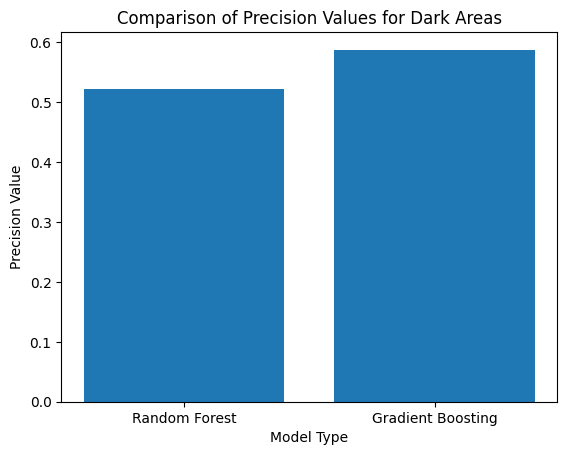

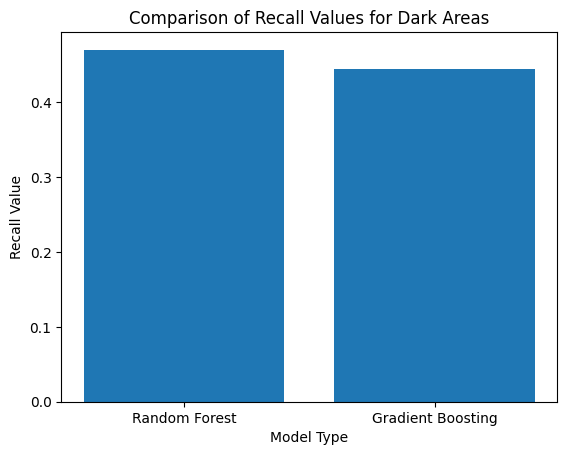

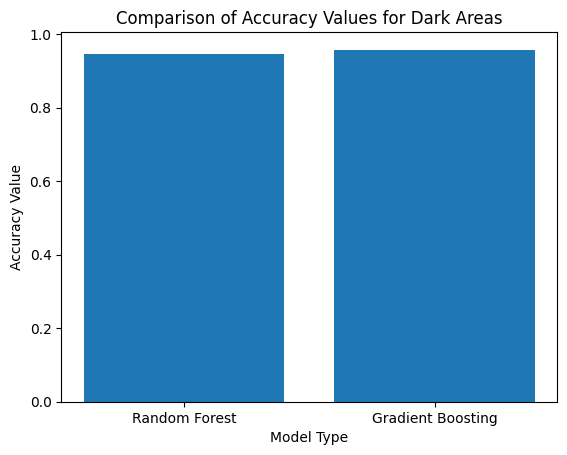

In [392]:
# Create a list of precision values
precision_values = [precision_dark, precision_dark_gb]

# Create a list of labels for the x-axis
labels = ['Random Forest', 'Gradient Boosting']
# Plot the bar chart
plt.bar(labels, precision_values)

# Add labels and title
plt.xlabel('Model Type')
plt.ylabel('Precision Value')
plt.title('Comparison of Precision Values for Dark Areas')

# Display the plot
plt.show()

# Create a list of recall values
recall_values = [recall_dark, recall_dark_gb]

# Create a list of labels for the x-axis

# Plot the bar chart
plt.bar(labels, recall_values)

# Add labels and title
plt.xlabel('Model Type')
plt.ylabel('Recall Value')
plt.title('Comparison of Recall Values for Dark Areas')
# Display the plot
plt.show()

# Create a list of accuracy values
accuracy_values = [accuracy_dark, accuracy_dark_gb]
# Create a list of labels for the x-axis


# Plot the bar chart
plt.bar(labels, accuracy_values)

# Add labels and title
plt.xlabel('Model Type')
plt.ylabel('Accuracy Value')
plt.title('Comparison of Accuracy Values for Dark Areas')
# Display the plot
plt.show()


**Future implementation**
1) Developing a better estimation of radius and distances of the devices from the sensors by setting an optimization problem based on the overlapping area points.
2) Check out for a possible implementation of LSTM for time series.
3) Clusterize the ID of the devices in order to group the same type of devices.